<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [ ]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

### Load Data From CSV File  

In [120]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [121]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [122]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [ ]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: - 

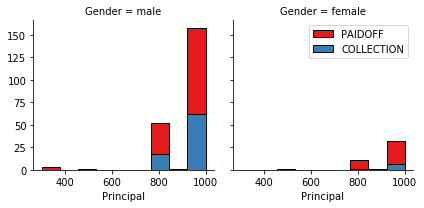

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

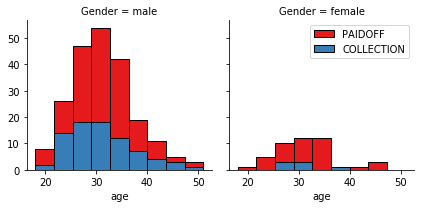

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

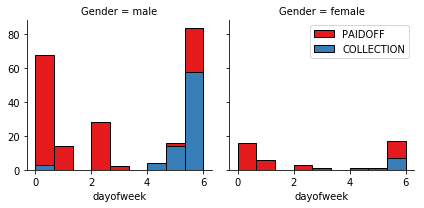

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek



In [ ]:
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [123]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

KeyError: 'dayofweek'

## Convert Categorical features to numerical values

Lets look at gender:

In [124]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [125]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0


## One Hot Encoding  
#### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [20]:
X.columns[:]

Index(['Principal', 'terms', 'age', 'Gender', 'weekend', 'Bechalor',
       'High School or Below', 'college'],
      dtype='object')

In [21]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [22]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import log_loss

In [30]:
# Let's split loan_train data into train and test set
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


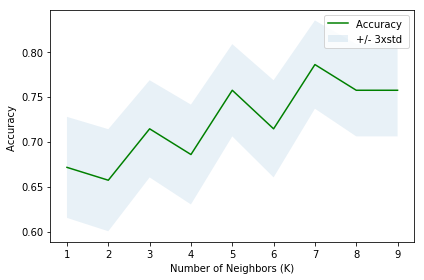

The best accuracy was with 0.7857142857142857 with k= 7


In [31]:
# Lte's find the best k value that gives the highest accuracy
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [32]:
# Let's try the KNN model again with the best k=7
k = 7
#Train Model and Predict  
loan_KNN = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat_KNN = loan_KNN.predict(X_test)


In [33]:
# Let's calculate the train and test set accuracies 

print("Train set Accuracy: ", metrics.accuracy_score(y_train, loan_KNN.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_KNN))
print("Jaccard score:", jaccard_similarity_score(y_test, yhat_KNN))
print("F1-score:", f1_score(y_test, yhat_KNN, average='weighted'))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_KNN, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_KNN))

Train set Accuracy:  0.8079710144927537
Test set Accuracy:  0.7857142857142857
Jaccard score: 0.7857142857142857
F1-score: 0.7766540244416351
              precision    recall  f1-score   support

  COLLECTION       0.50      0.40      0.44        15
     PAIDOFF       0.84      0.89      0.87        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.67      0.65      0.66        70
weighted avg       0.77      0.79      0.78        70



# Decision Tree

In [ ]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pydotplus-2.0.2            |     pyhd1c1de3_3          23 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

    pydotplus:       2.0.2-pyhd1c1de3_3 conda-forge
    python_abi:      3.6-1_cp36m        conda-forge

The following packages will be UPDATED:

 

In [35]:
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

In [36]:
# prediction using descision tree model
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree.fit(X_train,y_train)
predTree = loanTree.predict(X_test)

In [37]:
# Evaluation of the accuracy of training and test data
print("DecisionTrees's Train set Accuracy: ", metrics.accuracy_score(y_train, loanTree.predict(X_train)))
print("DecisionTrees's Test set Accuracy: ", metrics.accuracy_score(y_test, predTree))

print("Jaccard score:", jaccard_similarity_score(y_test, predTree))
print("F1-score:", f1_score(y_test, predTree, average='weighted'))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predTree, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, predTree))



DecisionTrees's Train set Accuracy:  0.7463768115942029
DecisionTrees's Test set Accuracy:  0.6142857142857143
Jaccard score: 0.6142857142857143
F1-score: 0.6445993031358885
              precision    recall  f1-score   support

  COLLECTION       0.27      0.47      0.34        15
     PAIDOFF       0.82      0.65      0.73        55

   micro avg       0.61      0.61      0.61        70
   macro avg       0.54      0.56      0.53        70
weighted avg       0.70      0.61      0.64        70



In [ ]:
import pydotplus
dot_data = StringIO()
filename = "loantree.png"
featureNames = X.columns[:]
targetNames = df['loan_status'].unique().tolist()
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

In [38]:
from sklearn import svm


In [40]:
loan_SVM = svm.SVC(kernel='rbf')
loan_SVM.fit(X_train, y_train) 
yhat_SVM = loan_SVM.predict(X_test)
yhat_SVM[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [41]:
# Evaluation of the accuracy of training and test data
print("DecisionTrees's Train set Accuracy: ", metrics.accuracy_score(y_train, loan_SVM.predict(X_train)))
print("DecisionTrees's Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_SVM))

print("Jaccard score:", jaccard_similarity_score(y_test, yhat_SVM))
print("F1-score:", f1_score(y_test, yhat_SVM, average='weighted'))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_SVM, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_SVM))

DecisionTrees's Train set Accuracy:  0.782608695652174
DecisionTrees's Test set Accuracy:  0.7428571428571429
Jaccard score: 0.7428571428571429
F1-score: 0.7275882012724117
              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

   micro avg       0.74      0.74      0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70



Confusion matrix, without normalization
[[48  7]
 [11  4]]


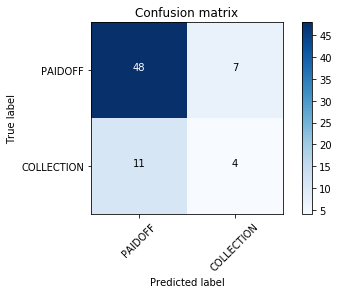

In [42]:

import itertools
#plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

# Logistic Regression

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [91]:
loan_LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat_LR = loan_LR.predict(X_test)
yhat_prob_LR = loan_LR.predict_proba(X_test)

DecisionTrees's Train set Accuracy:  0.7572463768115942
DecisionTrees's Test set Accuracy:  0.6857142857142857
Jaccard score: 0.6857142857142857
F1-score: 0.6670522459996144
LogLoss: 0.5772287609479654
              precision    recall  f1-score   support

  COLLECTION       0.18      0.13      0.15        15
     PAIDOFF       0.78      0.84      0.81        55

   micro avg       0.69      0.69      0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70

Confusion matrix, without normalization
[[46  9]
 [13  2]]


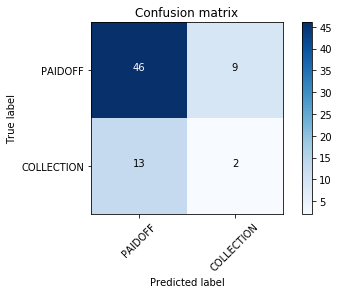

In [92]:
# Evaluation of the accuracy of training and test data
print("DecisionTrees's Train set Accuracy: ", metrics.accuracy_score(y_train, loan_LR.predict(X_train)))
print("DecisionTrees's Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_LR))

print("Jaccard score:", jaccard_similarity_score(y_test, yhat_LR))
print("F1-score:", f1_score(y_test, yhat_LR, average='weighted'))
print("LogLoss:", log_loss(y_test, yhat_prob_LR))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_LR, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_LR))


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,  classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

# Model Evaluation using Test set

In [50]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [51]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-09-13 17:18:25--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-09-13 17:18:26 (370 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [52]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [53]:
# Preprocessing of data

# 1. Convert datetime object
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

#2. Gender 
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# 3. add day of week
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# 4. 

test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,0,0,0,0
2,1000,30,43,1,0,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [54]:
X_test_orig=test_Feature
y_test_orig = test_df['loan_status'].values
X_test_orig= preprocessing.StandardScaler().fit(X_test_orig).transform(X_test_orig)
X_test_orig[0:5]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


array([[ 0.49,  0.93,  3.06,  1.98, -4.12,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51, -4.12, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98, -4.12, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.24, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.24,  2.4 , -0.8 , -0.86]])

Test set Accuracy:  0.6851851851851852
Jaccard score: 0.6851851851851852
F1-score: 0.6453810131971051
              precision    recall  f1-score   support

  COLLECTION       0.29      0.14      0.19        14
     PAIDOFF       0.74      0.88      0.80        40

   micro avg       0.69      0.69      0.69        54
   macro avg       0.52      0.51      0.50        54
weighted avg       0.63      0.69      0.65        54

Confusion matrix, without normalization
[[35  5]
 [12  2]]
0.6851851851851852


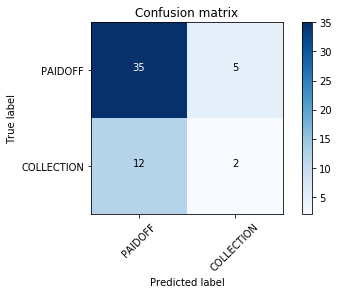

In [98]:
# MODEL EVALUATION

# 1. KNN MODEL
k = 7
#Train Model and Predict  
yhat_test_KNN = loan_KNN.predict(X_test_orig)

print("Test set Accuracy: ", metrics.accuracy_score(y_test_orig, yhat_test_KNN))

print("Jaccard score:", jaccard_similarity_score(y_test_orig, yhat_test_KNN))
J_KNN=jaccard_similarity_score(y_test_orig, yhat_test_KNN)

print("F1-score:", f1_score(y_test_orig, yhat_test_KNN, average='weighted'))
F1_KNN=f1_score(y_test_orig, yhat_test_KNN, average='weighted')



# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_orig,yhat_test_KNN,labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test_orig, yhat_test_KNN))


# Plot non-normalized confusion matrix

plt.figure()
plot_confusion_matrix(cnf_matrix,  classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')


Test set Accuracy:  0.5185185185185185
Jaccard-score: 0.5185185185185185
F1-score: 0.5385802469135802
              precision    recall  f1-score   support

  COLLECTION       0.32      0.79      0.46        14
     PAIDOFF       0.85      0.42      0.57        40

   micro avg       0.52      0.52      0.52        54
   macro avg       0.59      0.61      0.51        54
weighted avg       0.71      0.52      0.54        54

Confusion matrix, without normalization
[[17 23]
 [ 3 11]]


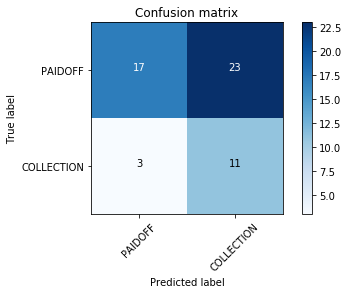

In [100]:
# Model Evaluation
# 2. Decsision tree
yhat_test_tree = loanTree.predict(X_test_orig)

print("Test set Accuracy: ", metrics.accuracy_score(y_test_orig, yhat_test_tree ))

print("Jaccard-score:", jaccard_similarity_score(y_test_orig, yhat_test_tree ))
J_tree=jaccard_similarity_score(y_test_orig, yhat_test_tree )


print("F1-score:", f1_score(y_test_orig, yhat_test_tree , average='weighted'))
F1_tree=f1_score(y_test_orig, yhat_test_tree, average='weighted')


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_orig, yhat_test_tree, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test_orig, yhat_test_tree ))

# Plot non-normalized confusion matrix

plt.figure()
plot_confusion_matrix(cnf_matrix,  classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

Test set Accuracy:  0.8148148148148148
Jaccard-score: 0.8148148148148148
F1-score: 0.7861952861952862
              precision    recall  f1-score   support

  COLLECTION       0.83      0.36      0.50        14
     PAIDOFF       0.81      0.97      0.89        40

   micro avg       0.81      0.81      0.81        54
   macro avg       0.82      0.67      0.69        54
weighted avg       0.82      0.81      0.79        54

Confusion matrix, without normalization
[[39  1]
 [ 9  5]]


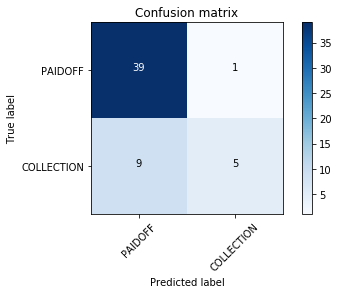

In [101]:
# Model evaluation

# 3. SVM
yhat_test_SVM = loan_SVM.predict(X_test_orig)

print("Test set Accuracy: ", metrics.accuracy_score(y_test_orig, yhat_test_SVM ))

print("Jaccard-score:", jaccard_similarity_score(y_test_orig, yhat_test_SVM ))
J_SVM=jaccard_similarity_score(y_test_orig, yhat_test_SVM )

print("F1-score:", f1_score(y_test_orig, yhat_test_SVM , average='weighted'))

F1_SVM=f1_score(y_test_orig, yhat_test_SVM, average='weighted')


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_orig, yhat_test_SVM, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test_orig, yhat_test_SVM ))

# Plot non-normalized confusion matrix

plt.figure()
plot_confusion_matrix(cnf_matrix,  classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

Test set Accuracy:  0.7407407407407407
Jaccard-score: 0.7407407407407407
F1-score: 0.6304176516942475
LogLoss: 0.6037871272191607
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        14
     PAIDOFF       0.74      1.00      0.85        40

   micro avg       0.74      0.74      0.74        54
   macro avg       0.37      0.50      0.43        54
weighted avg       0.55      0.74      0.63        54

Confusion matrix, without normalization
[[40  0]
 [14  0]]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, 

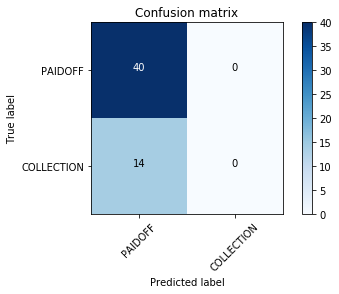

In [103]:
# Model evaluation

# 4. Logistic regression
yhat_test_LR = loan_LR.predict(X_test_orig)
yhat_test_prob = loan_LR.predict_proba(X_test_orig)

print("Test set Accuracy: ", metrics.accuracy_score(y_test_orig, yhat_test_LR ))

print("Jaccard-score:", jaccard_similarity_score(y_test_orig, yhat_test_LR ))
J_LR=jaccard_similarity_score(y_test_orig, yhat_test_LR )


print("F1-score:", f1_score(y_test_orig, yhat_test_LR , average='weighted'))
F1_LR=f1_score(y_test_orig, yhat_test_LR, average='weighted')

print("LogLoss:", log_loss(y_test_orig, yhat_test_prob))
LL=log_loss(y_test_orig, yhat_test_prob)



# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_orig, yhat_test_LR, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test_orig, yhat_test_LR))

# Plot non-normalized confusion matrix

plt.figure()
plot_confusion_matrix(cnf_matrix,  classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [115]:
Algorithm=["KNN","Decision Tree", "SVM", "LogisticRegression"]
Jaccard=[J_KNN, J_tree, J_SVM, J_LR]
F1_score=[F1_KNN, F1_tree, F1_SVM, F1_LR]
LogLoss= ["N/A", "N/A", "N/A", LL]
acc=pd.DataFrame({'Algorithm':Algorithm[:],'Jaccard': Jaccard[:], 'F1-score': F1_score[:], 'LogLoss': LogLoss[:] })
acc.set_index('Algorithm')

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.685185,0.538580,N/A
Decision Tree,0.518519,0.538580,N/A
SVM,0.814815,0.786195,N/A
LogisticRegression,0.740741,0.630418,0.603787


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>